# Process gridded observation data into timeseries

__1. Process the gridded temperature data into timeseries for each observational product.__

Output is a dataArray for each model with dimensions of time and IPCC region containing a time series of the TAS variable.


Use this tool:  

https://github.com/IPCC-WG1/Atlas/blob/main/notebooks/reference-regions_Python.ipynb

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

In [7]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, pd
    )

%matplotlib inline

__Observational Large Ensembles.__

General directory in Nathan's scratch: /glade/scratch/lenssen/data_for_jonah/

NASA GISTEMP: GISTEMP_2x2  GISTEMP_5x5

HadCRUT5: HadCRUT5

In [8]:
gistemp_2x2_dir = '/glade/scratch/lenssen/data_for_jonah/GISTEMP_2x2/'
gistemp_5x5_dir = '/glade/scratch/lenssen/data_for_jonah/GISTEMP_5x5/'
hadcrut5_dir    = '/glade/scratch/lenssen/data_for_jonah/HadCRUT5/'

### Collect file paths.

#### Collect GISTEMP 2x2 file paths.

In [9]:
gistemp_2x2_files = glob.glob('%s/ensembleChunk_???.nc' % gistemp_2x2_dir)
gistemp_2x2_files.sort()

#### Collect GISTEMP 5x5 file paths.

In [10]:
gistemp_5x5_files = glob.glob('%s/ensembleChunk_5x5_???.nc' % gistemp_5x5_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [11]:
hadcrut5_files = glob.glob('%s/HadCRUT.5.0.1.0.analysis.anomalies.*.nc' % hadcrut5_dir)
hadcrut5_files.sort()

### Load and process timeseries according to IPCC Region designations.

#### 1. Visualize the IPCC AR6 regions

In [1]:
import regionmask

regionmask.__version__

ModuleNotFoundError: No module named 'regionmask'

In [6]:
import cartopy.crs as ccrs
import matplotlib.patheffects as pe

### 2. Do masking for each dataset

#### GISTEMP 2x2

Variable is "tempAnom". "record" coordinate will allow for easier concatenation.

In [7]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'

### Loop over observation files and compute the regional means.

In [10]:
def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions,cesm=False,ufunc=None,
                                 lon=None,lat=None,lon_name='lon',lat_name='lat'):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    '''
    # Load data
    ds      = xr.open_dataset(_ds_filepath,chunks={lat_name:-1,lon_name:-1})
    
    # Correct time if CESM
    if cesm:
        ds  = fix_cesm_time(ds)
    
    da      = ds[_ds_var]
    
    if (ufunc is not None):
        da = ufunc(da) #.sel(time=slice(1960,None))
    # da = da.chunk(chunks={'lat':-1,'lon':-1,'record':1}) # JKS speed-up attempt
    
    # Generate mask
    if ((lon is not None) and (lat is not None)):
        print('Using "lat" and "lon" supplied as input')
        
        # Make sure the passed grid values match the data approximately.
        np.testing.assert_allclose(lat,da['lat'],atol=5e-2,rtol=1e-1,err_msg='Supplied latitudes do not match data')
        np.testing.assert_allclose(lon,da['lon'],atol=5e-2,rtol=1e-1,err_msg='Supplied longitudes do not match data')
        
        mask    = regions.mask(lon,lat=lat)
        
        da['lon'] = lon
        da['lat'] = lat
        
    else:
        mask    = regions.mask(da)
    
    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]
    
    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names
    
    # Compute weights for entire grid
    weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
    # Iterate over regions and compute a weighted time series
    region_timeseries = []
    for i,_abbrev,_name in zip(reg,abbrevs,names):
        
        _region = da.where(mask == i)
        
        _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
        # Using an int here should help with subsetting later.
        _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

        # Include region abbreviation and name for easier use later
        _region_avg = _region_avg.assign_coords({'RegionAbbrev':_abbrev})
        _region_avg = _region_avg.assign_coords({'RegionName':_name})
        
        region_timeseries.append(_region_avg)
        
    region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
    region_timeseries_ds.name = _ds_var
        
    return region_timeseries_ds

In [9]:
save_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### GISTEMP 2x2

In [11]:
# Arbitrary function to apply

def gistemp_2x2_tselect(da:xr.DataArray):
    
    return da.sel(time=slice(1900, None))

In [12]:
%%time

gistemp_new_times = (pd.date_range("1900-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')
model_subdir = 'GISTEMP_2x2/'

# Variable to select and operate over.
_ds_var = gistemp_tas_var

for _ds_filepath in gistemp_2x2_files:
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=gistemp_2x2_tselect
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    _regional_tseries = _regional_tseries.assign_coords(time_dt=('time', gistemp_new_times)) # Add a reasonable time dimension
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)
    
    # break

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_001.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_002.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_003.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_004.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_005.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_006.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_007.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_008.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_009.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_2x2//ensembleChunk_010.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan

In [14]:
ex_gistemp_2x2_tseries = _regional_tseries

#### GISTEMP 5x5

The coordinate labelling here is kind of weird and harder to work with.

In [13]:
# Arbitrary function to apply

def gistemp_5x5_tselect(da:xr.DataArray):
    
    return da.sel(time_2=slice(1900,None)).rename({'longitude':'lon','latitude':'lat'})

In [15]:
%%time

gistemp_new_times = (pd.date_range("1900-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')
model_subdir = 'GISTEMP_5x5/'

# Variable to select and operate over.
_ds_var = gistemp_tas_var

for i,_ds_filepath in enumerate(gistemp_5x5_files):
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=gistemp_5x5_tselect,
                                                             lon_name='longitude',
                                                             lat_name='latitude',
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    _regional_tseries = _regional_tseries.assign_coords(time_dt=('time_2', gistemp_new_times)) # Add a reasonable time dimension
    
    # Fix coordinate issues so concatenation is easier.
    _regional_tseries = _regional_tseries.rename({'time':'record'})
    _regional_tseries['record'] = 2*i + np.arange(1,2.1,1) # Updated 5x5 version from Nathan only has 2 sub-members per file?
    # _regional_tseries['record'] = 10*i + np.arange(1,10.1,1)
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)
    

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_001.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_002.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_003.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_004.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_005.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_006.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_007.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_008.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_009.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//GISTEMP_5x5//ensembleChunk_5x5_010.nc
/glade/u/h

In [17]:
ex_gistemp_5x5_tseries = _regional_tseries

#### HadCRUT5

In [32]:
# Arbitrary function to apply

def hadcrut5_tselect(da:xr.DataArray):
    
    return da.sel(time=slice('1900-01-01','2022-12-31')).rename({'longitude':'lon','latitude':'lat'})

In [34]:
%%time

model_subdir = 'HadCRUT5/'

# Variable to select and operate over.
_ds_var = hadcrut5_tas_var

for _ds_filepath in hadcrut5_files:

    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=False,
                                                             ufunc=hadcrut5_tselect,
                                                             lon_name='longitude',
                                                             lat_name='latitude',
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    _regional_tseries = _regional_tseries.expand_dims('realization')
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)
    
    # break

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.1.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.10.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.100.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.101.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.102.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.103.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.104.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.105.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS//HadCRUT5//HadCRUT.5.0.1.0.analysis.ano

In [20]:
ex_hadcrut5_tseries = _regional_tseries

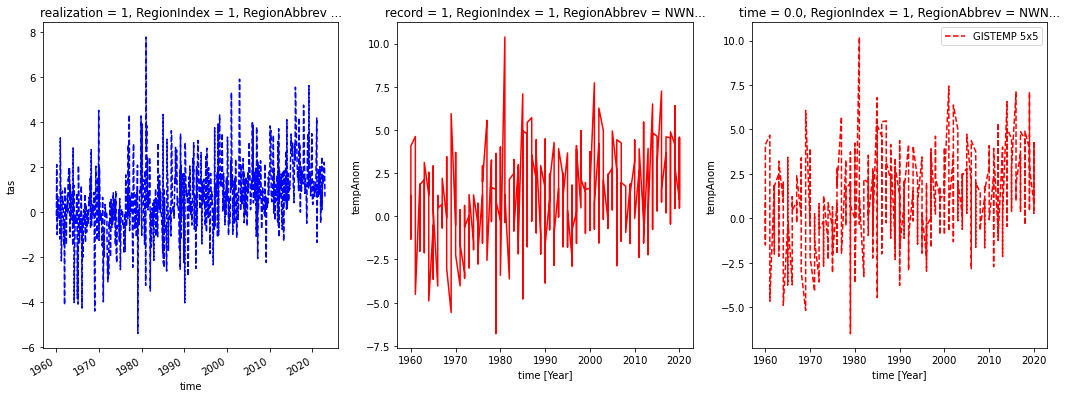

In [21]:
fig,axs = plt.subplots(1,3,figsize=(18,6))

region_index = 1

ex_hadcrut5_tseries.sel(RegionIndex=region_index).plot(color='blue',label='HadCRUT5',linestyle='dashed',ax=axs[0])

ex_gistemp_2x2_tseries.sel(RegionIndex=region_index,record=1).plot(color='red',label='GISTEMP 2x2',ax=axs[1])

ex_gistemp_5x5_tseries.sel(RegionIndex=region_index).isel(time=0).plot(color='red',label='GISTEMP 5x5',linestyle='dashed',ax=axs[2])

plt.legend()

In [24]:
pd.date_range("2000-01-01", freq="H", periods=365 * 24)

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:00:00',
               '2000-01-01 02:00:00', '2000-01-01 03:00:00',
               '2000-01-01 04:00:00', '2000-01-01 05:00:00',
               '2000-01-01 06:00:00', '2000-01-01 07:00:00',
               '2000-01-01 08:00:00', '2000-01-01 09:00:00',
               ...
               '2000-12-30 14:00:00', '2000-12-30 15:00:00',
               '2000-12-30 16:00:00', '2000-12-30 17:00:00',
               '2000-12-30 18:00:00', '2000-12-30 19:00:00',
               '2000-12-30 20:00:00', '2000-12-30 21:00:00',
               '2000-12-30 22:00:00', '2000-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [34]:
gistemp_new_times = (pd.date_range("1900-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')

DatetimeIndex(['1960-01-15', '1960-02-15', '1960-03-15', '1960-04-15',
               '1960-05-15', '1960-06-15', '1960-07-15', '1960-08-15',
               '1960-09-15', '1960-10-15',
               ...
               '2020-03-15', '2020-04-15', '2020-05-15', '2020-06-15',
               '2020-07-15', '2020-08-15', '2020-09-15', '2020-10-15',
               '2020-11-15', '2020-12-15'],
              dtype='datetime64[ns]', length=732, freq=None)

In [27]:
out = pd.date_range("1900-01-01", freq="M", periods=12*61)

In [28]:
out.shift(periods=-15,freq='D')

DatetimeIndex(['1960-01-16', '1960-02-14', '1960-03-16', '1960-04-15',
               '1960-05-16', '1960-06-15', '1960-07-16', '1960-08-16',
               '1960-09-15', '1960-10-16',
               ...
               '2020-03-16', '2020-04-15', '2020-05-16', '2020-06-15',
               '2020-07-16', '2020-08-16', '2020-09-15', '2020-10-16',
               '2020-11-15', '2020-12-16'],
              dtype='datetime64[ns]', length=732, freq=None)

In [ ]:
pd.date

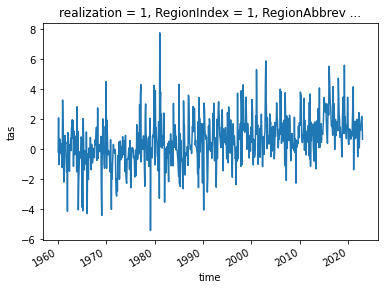

In [97]:
_regional_tseries.sel(RegionIndex=1).plot()

#### CESM1-CAM5 (CESM1-LE)

In [23]:
model_subdir = 'CESM1/'

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

for _ds_filepath in cesm1_pic_path_dict['tas']:
    # break
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=True,
                                                            )
    _regional_tseries = _regional_tseries_delayed.compute()
    break
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)

Create mask.

In [14]:
regionmask.defined_regions.ar6.land

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)
overlap:  False

Regions:
  0  GIC  Greenland/Iceland
  1  NWN  N.W.North-America
  2  NEN  N.E.North-America
  3  WNA    W.North-America
  4  CNA    C.North-America
..   ...                ...
 41  EAU        E.Australia
 42  SAU        S.Australia
 43   NZ        New-Zealand
 44  EAN       E.Antarctica
 45  WAN       W.Antarctica

[46 regions]

In [15]:
mask = regionmask.defined_regions.ar6.land.mask(ex_tas_da)

In [16]:
mask_fake = regionmask.defined_regions.ar6.land.mask(mpi_lons,mpi_lats)

In [ ]:
# mask_mpi = regionmask.defined_regions.ar6.land.mask(ex_mpi_tas_ds) # kills the kernel!

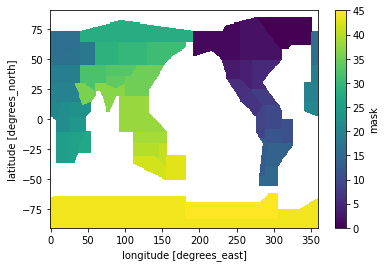

In [18]:
mask.plot()

In [16]:
mask

<xarray.DataArray 'mask' (lat: 192, lon: 288)>
array([[44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

Oh cool! The mask has the value corresponding to the region's index?

In [17]:
# for colorbar: find abbreviations of all regions that were selected
reg = np.unique(mask.values)
reg = reg[~np.isnan(reg)]
abbrevs = regionmask.defined_regions.ar6.land[reg].abbrevs
names   = regionmask.defined_regions.ar6.land[reg].names

The CNA (central north america) region is index 4.

In [18]:
CNA_index = regionmask.defined_regions.ar6.land.map_keys("C.North-America")

In [19]:
# Mask out (in) a region
airtemps_CNA = ex_tas_da.where(mask == CNA_index)

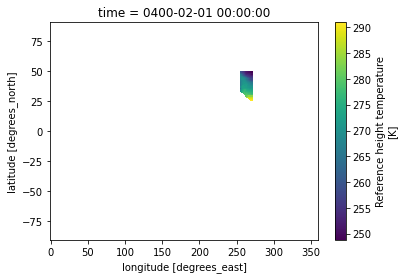

In [20]:
airtemps_CNA.isel(time=0).plot()

In [21]:
weights = np.cos(np.deg2rad(airtemps_CNA.lat))

ts_airtemps_CNA = airtemps_CNA.weighted(weights).mean(dim=("lat", "lon")) - 273.15

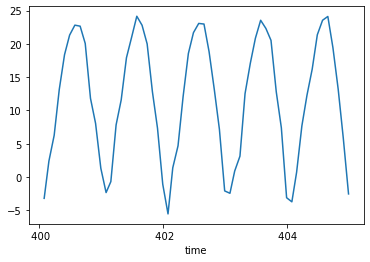

In [22]:
ts_airtemps_CNA.isel(time=slice(None,60)).plot()

### Write a function to compute timeseries for all IPCC AR6 regions when given a simple model output file.

In [23]:
# Filepath to a netcdf dataset.
_ds_filepath = cesm1_pic_path_dict['tas'][0]

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

In [24]:
def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    '''

    # Load data
    ds      = xr.open_dataset(_ds_filepath,chunks={'lat':-1,'lon':-1}) 
    da      = ds[_ds_var]
    
    # Generate mask
    mask    = regions.mask(da)
    
    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]
    
    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names
    
    # Compute weights for entire grid
    weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
    # Iterate over regions and compute a weighted time series
    region_timeseries = []
    for i,_abbrev,_name in zip(reg,abbrevs,names):
        
        _region = da.where(mask == i)
        
        _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
        # Using an int here should help with subsetting later.
        _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

        # Include region abbreviation and name for easier use later
        _region_avg = _region_avg.assign_coords({'RegionName':_abbrev})
        _region_avg = _region_avg.assign_coords({'RegionAbbrev':_name})
        
        region_timeseries.append(_region_avg)
        
    region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
        
    return region_timeseries_ds

In [25]:
%%time

out = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,_ds_var=_ds_var,regions=regionmask.defined_regions.ar6.land)

CPU times: user 781 ms, sys: 8.3 ms, total: 789 ms
Wall time: 804 ms


In [26]:
%%time

# Everything is delayed, so the real computations take a bit longer (30s for 100 years of CESM1 data, not bad!)
testout = out.compute()

CPU times: user 19.7 s, sys: 11 s, total: 30.7 s
Wall time: 31.8 s


Test it!

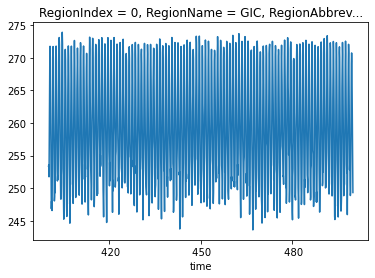

In [27]:
testout.sel(RegionIndex=0).plot()

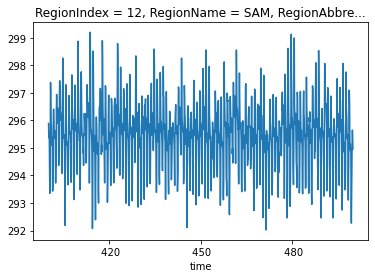

In [28]:
testout.sel(RegionIndex=12).plot()